In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations
import seaborn as sns
%load_ext rpy2.ipython

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Upload file conposcovidloc.csv vào ggdrive
#Chạy đoạn lệnh bên dưới để cấp quyền vào drive
from google.colab import drive 
drive.mount('/content/gdrive',force_remount=True)
#Vào URL bên dưới để đăng nhập vào drive, rồi cope authorize code vào ô bên dưới

Mounted at /content/gdrive


#Sau khi cấp quyền vào drive, thư mục đã upload trong drive sẽ như bên dưới

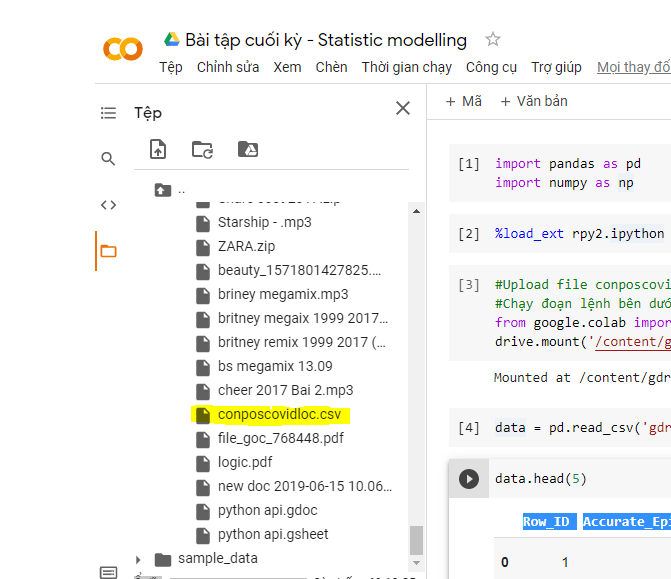

In [3]:
#Đọc data từ file csv trong drive
data = pd.read_csv('gdrive/MyDrive/conposcovidloc.csv')

In [4]:
#Hiển thị dữ liệu
data.head(5)

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-04-24,2020-05-01,2020-05-01,2020-04-24,50s,MALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
1,2,2020-04-07,2020-04-24,2020-04-24,2020-04-22,40s,FEMALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
2,3,2020-05-29,2020-06-05,2020-06-05,2020-06-05,50s,FEMALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
3,4,2020-03-26,2020-03-30,2020-03-30,2020-03-26,40s,MALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
4,5,2020-05-17,2020-05-18,2020-05-18,2020-05-17,40s,FEMALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893


In [5]:
#Data có 536,607 mẫu
#Một số features quan trọng: Age_Group, Client_Gender, Case_AcquisitionInfo, Outcome1, Outbreak_Related, Reporting_PHU_City
data.describe(include= 'all')

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
count,536607.000000,536607,536607,524146,534265,536607,536607,536607,536607,90858,536607.000000,536607,536607,536607,536607,536607,536607.000000,536607.000000
unique,NaN,493,470,472,476,10,4,6,3,1,NaN,34,34,34,34,34,NaN,NaN
top,NaN,2021-04-07,2021-04-14,2021-04-14,2021-04-12,20s,MALE,CC,Resolved,Yes,NaN,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,NaN,NaN
freq,NaN,4729,5071,5033,4978,113602,267207,238831,519801,90858,NaN,163249,163249,163249,163249,163249,NaN,NaN
mean,268304.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2781.221020,NaN,NaN,NaN,NaN,NaN,43.777380,-79.583939
std,154905.242287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,788.317022,NaN,NaN,NaN,NaN,NaN,0.791399,1.649377
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2226.000000,NaN,NaN,NaN,NaN,NaN,42.308796,-94.488254
25%,134152.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2251.000000,NaN,NaN,NaN,NaN,NaN,43.647471,-79.708893
50%,268304.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2260.000000,NaN,NaN,NaN,NaN,NaN,43.656591,-79.480239
75%,402455.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3895.000000,NaN,NaN,NaN,NaN,NaN,43.898605,-79.379358


In [6]:
#Distinct những giá trị hiện có trong các features 
for col in data:
    if col in ['Age_Group', 'Client_Gender', 'Case_AcquisitionInfo', 'Outcome1', 'Outbreak_Related', 'Reporting_PHU_City']:
          print(col, data[col].unique())

Age_Group ['50s' '40s' '60s' '30s' '20s' '80s' '70s' '<20' '90+' 'UNKNOWN']
Client_Gender ['MALE' 'FEMALE' 'UNSPECIFIED' 'GENDER DIVERSE']
Case_AcquisitionInfo ['OB' 'CC' 'NO KNOWN EPI LINK' 'TRAVEL' 'UNSPECIFIED EPI LINK'
 'MISSING INFORMATION']
Outcome1 ['Resolved' 'Fatal' 'Not Resolved']
Outbreak_Related ['Yes' nan]
Reporting_PHU_City ['Mississauga' 'Oakville' 'Kingston' 'Guelph' 'Toronto' 'Owen Sound'
 'Thorold' 'Hamilton' 'Windsor' 'Waterloo' 'Cornwall' 'Stratford'
 'Point Edward' 'Newmarket' 'Port Hope' 'Barrie' 'Peterborough' 'Simcoe'
 'St. Thomas' 'Kenora' 'Brockville' 'Chatham' 'Whitby' 'Sault Ste. Marie'
 'London' 'Sudbury' 'Brantford' 'Belleville' 'Thunder Bay' 'New Liskeard'
 'Ottawa' 'North Bay' 'Pembroke' 'Timmins']


# Noted:
- OB: outbreak VD: lây nhiễm liên quan đến ổ dịch

- CC: Close contact VD: lây nhiễm do tiếp xúc với các ca F
 
- NO KNOWN EPI LINK: Không có liên hệ về dịch tễ VD: lây nhiễm cộng đồng

- UnSpecified Epi link: chưa phân loại được nguyên nhân

**CLEANING DATA**

In [7]:
#Count số lượng các mẫu có giá trị lỗi: khoảng 10% tổng số lượng mẫu (55,539 mẫu lỗi)
error_data = data[(data['Age_Group'] == 'UNKNOWN') | (data ['Client_Gender'] == 'UNSPECIFIED') | (data ['Client_Gender'] == 'GENDER DIVERSE') | 
      (data['Case_AcquisitionInfo'] == 'UNSPECIFIED EPI LINK') | (data['Case_AcquisitionInfo'] == 'MISSING INFORMATION') ]
error_data.iloc[:, 0].count()

55539

In [8]:
#Giữ lại các biến quan trọng Age_Group, Client_Gender, Case_AcquisitionInfo, Reporting_PHU_City và loại bỏ các mẫu có giá trị lỗi
data_new = data[~ data.index.isin(error_data.index)]
data_new.iloc[:, 0].count()

481068

In [9]:
data_new.head(5)

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-04-24,2020-05-01,2020-05-01,2020-04-24,50s,MALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
1,2,2020-04-07,2020-04-24,2020-04-24,2020-04-22,40s,FEMALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
2,3,2020-05-29,2020-06-05,2020-06-05,2020-06-05,50s,FEMALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
3,4,2020-03-26,2020-03-30,2020-03-30,2020-03-26,40s,MALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
4,5,2020-05-17,2020-05-18,2020-05-18,2020-05-17,40s,FEMALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893


**EXPLORE DATA**

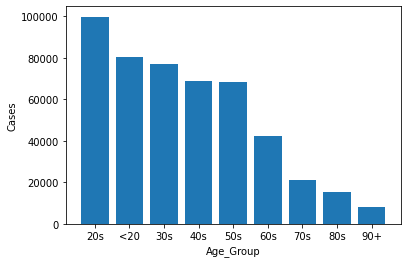

In [10]:
##EDA
from matplotlib import pyplot as plt
age_group = data_new['Row_ID'].groupby(data_new['Age_Group']).count().reset_index()
age_group = age_group.sort_values(by = 'Row_ID', ascending = False)
plt.bar(age_group.iloc[:, 0], age_group.iloc[:, 1])
plt.xlabel("Age_Group")
plt.ylabel("Cases")
plt.show()


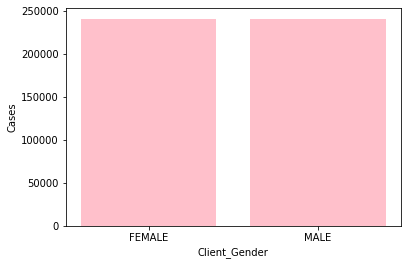

In [11]:
##EDA
from matplotlib import pyplot as plt
gender = data_new['Row_ID'].groupby(data_new['Client_Gender']).count().reset_index()
gender = gender.sort_values(by = 'Row_ID', ascending = False)
plt.bar(gender.iloc[:, 0], gender.iloc[:, 1], color = 'pink')
plt.xlabel("Client_Gender")
plt.ylabel("Cases")
plt.show()
#=> Có vẻ như giới tính không ảnh hưởng đến số ca mắc bệnh

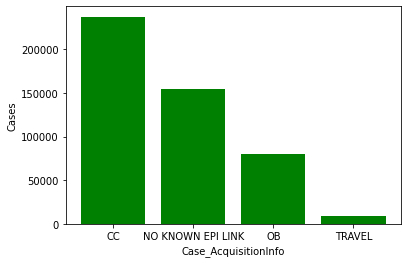

In [12]:
##EDA
from matplotlib import pyplot as plt
infor = data_new['Row_ID'].groupby(data_new['Case_AcquisitionInfo']).count().reset_index()
infor = infor.sort_values(by = 'Row_ID', ascending = False)
plt.bar(infor.iloc[:, 0], infor.iloc[:, 1], color = 'green')
plt.xlabel("Case_AcquisitionInfo")
plt.ylabel("Cases")
plt.show()

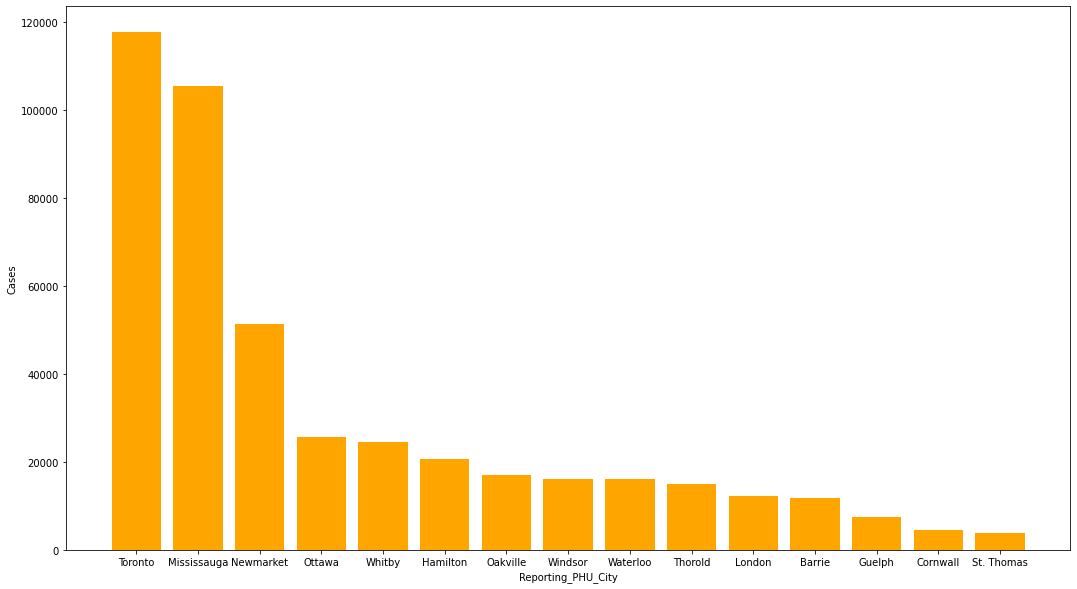

In [13]:
##EDA
from matplotlib import pyplot as plt
fig = plt.gcf()
fig.set_size_inches(18, 10)


city = data_new['Row_ID'].groupby(data_new['Reporting_PHU_City']).count().reset_index()
city = city.sort_values(by = 'Row_ID', ascending = False).head(15)
plt.bar(city.iloc[:, 0], city.iloc[:, 1], color = 'orange', width = 0.8)
plt.xlabel("Reporting_PHU_City")
plt.ylabel("Cases")
plt.show()

**TRANSFORM DATA**

In [14]:
#Đọc data về dân số từ file csv trong drive
population = pd.read_csv('gdrive/MyDrive/Canadapopulation2021.csv')

In [15]:
population.head(10)

,Cities,Population,Classify
0,Mississauga,"668,549.00",Large urban
1,Oakville,"221,688.00",Large urban
2,Kingston,"117,660.00",Large urban
3,Guelph,"132,397.00",Large urban
4,Toronto,"5,429,524.00",Large urban
5,Owen Sound,"21,559.00",Small
6,Thorold,"17,359.00",Small
7,Hamilton,"693,645.00",Large urban
8,Windsor,"287,069.00",Large urban
9,Waterloo,"571,000.00",Large urban


In [16]:
#Chuyển đổi từ tên thành phố về phân loại thành phố lớn, vừa và nhỏ theo dân số (đối chiếu với dataframe population)
data_new2 = pd.merge(data_new, population[['Classify','Cities']], how='inner', left_on='Reporting_PHU_City', right_on ='Cities').drop(['Cities'], axis=1)
data_new2

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Classify
0,1,2020-04-24,2020-05-01,2020-05-01,2020-04-24,50s,MALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893,Large urban
1,2,2020-04-07,2020-04-24,2020-04-24,2020-04-22,40s,FEMALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893,Large urban
2,3,2020-05-29,2020-06-05,2020-06-05,2020-06-05,50s,FEMALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893,Large urban
3,4,2020-03-26,2020-03-30,2020-03-30,2020-03-26,40s,MALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893,Large urban
4,5,2020-05-17,2020-05-18,2020-05-18,2020-05-17,40s,FEMALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893,Large urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481063,533962,2021-04-25,2021-04-25,2021-04-28,2021-04-27,50s,MALE,CC,Resolved,NaN,2256,Porcupine Health Unit,169 Pine Street South,Timmins,P4N 8B7,www.porcupinehu.on.ca,48.472510,-81.328750,Small
481064,534264,2021-04-17,2021-04-26,2021-04-26,2021-04-21,60s,MALE,CC,Resolved,NaN,2256,Porcupine Health Unit,169 Pine Street South,Timmins,P4N 8B7,www.porcupinehu.on.ca,48.472510,-81.328750,Small
481065,534417,2021-05-20,2021-05-25,2021-05-25,2021-05-25,30s,FEMALE,CC,Resolved,NaN,2256,Porcupine Health Unit,169 Pine Street South,Timmins,P4N 8B7,www.porcupinehu.on.ca,48.472510,-81.328750,Small
481066,534419,2021-05-21,2021-05-25,2021-05-25,2021-05-24,20s,FEMALE,NO KNOWN EPI LINK,Resolved,NaN,2256,Porcupine Health Unit,169 Pine Street South,Timmins,P4N 8B7,www.porcupinehu.on.ca,48.472510,-81.328750,Small


In [17]:
#Đổi tên 1 số cột trong dataframe
data_new2 = data_new2.rename(columns = {'Classify': 'Cities', 'Case_AcquisitionInfo' : 'Case_info' }, inplace = False)

In [18]:
#Chuyển đổi range tuổi thành 3 nhóm: youth, adult, senior
data_new2.loc[data_new2['Age_Group'].isin(['<20', '20s']), 'Age'] = 'youth'
data_new2.loc[data_new2['Age_Group'].isin(['30s','40s','50s','60s']), 'Age'] = 'adult'
data_new2.loc[data_new2['Age_Group'].isin(['70s','80s','90+']), 'Age'] = 'senior'

In [19]:
#Group by data để đếm số cases 
data_final = data_new2.loc[: , ['Age', 'Cities', 'Case_info','Client_Gender','Row_ID']].groupby(['Age', 'Cities', 'Case_info','Client_Gender']).count()

In [20]:
#Reset lại index cho data frame sau khi GRoup by
data_final = data_final.reset_index()

In [21]:
# Đổi tên cột Row_ID thành "cases" =>> Hoàn tất chuyển đổi dữ liệu
data_final.rename(columns = {'Row_ID': 'Cases'}, inplace= True)
data_final

,Age,Cities,Case_info,Client_Gender,Cases
0,adult,Large urban,CC,FEMALE,45818
1,adult,Large urban,CC,MALE,40225
2,adult,Large urban,NO KNOWN EPI LINK,FEMALE,36451
3,adult,Large urban,NO KNOWN EPI LINK,MALE,40915
4,adult,Large urban,OB,FEMALE,16860
...,...,...,...,...,...
67,youth,Small,NO KNOWN EPI LINK,MALE,3706
68,youth,Small,OB,FEMALE,1479
69,youth,Small,OB,MALE,1491
70,youth,Small,TRAVEL,FEMALE,170


**BUILD MODEL**

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

**Kiếm tra xem có hiện tượng overdisperson không**

In [23]:
#Kiếm tra mean, variance của biến phụ thuộc Cases:
print('mean: ', np.mean(data_final['Cases']), 'var: ', np.var(data_final['Cases']) ) 
# Có hiện tượng overdisperson

mean:  6681.5 var:  132372410.19444445


**TEST DEPENDENCY OF VARIABLES**

In [24]:
pivot_df = data_final.groupby(['Age','Cities']).sum().reset_index().pivot(index='Age', columns='Cities', values='Cases')
pivot_df

Cities,Large urban,Medium,Small
Age,,,
adult,199361,12361,44668
senior,33805,2617,8319
youth,143245,9136,27556


In [25]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(pivot_df, correction=False)
print('chi2', chi2, 'pvalue', '{:.10f}'.format(p))
#Ho: Age, Cities độc lập,no relationship exists on the categorical variables

chi2 556.0837965894341 pvalue 0.0000000000


In [26]:
#Kiểm tra tính độc lập với hai biến Age và Case_info
pivot_df = data_final.groupby(['Age','Case_info']).sum().reset_index().pivot(index='Age', columns='Case_info', values='Cases')
pivot_df
chi2, p, dof, ex = chi2_contingency(pivot_df, correction=False)
print('chi2', chi2, 'pvalue','{:.10f}'.format(p))


chi2 40763.925430080795 pvalue 0.0000000000


In [27]:
#Kiểm tra tính độc lập với hai biến Cities và Case_info
pivot_df = data_final.groupby(['Cities','Case_info']).sum().reset_index().pivot(index='Cities', columns='Case_info', values='Cases')
pivot_df
chi2, p, dof, ex = chi2_contingency(pivot_df, correction=False)
print('chi2', chi2,'pvalue', '{:.10f}'.format(p))

chi2 2481.1663786535687 pvalue 0.0000000000


In [28]:
#Chạy thử các khả năng model với pp Poisson
#Liệt kê tất cả các khả năng của model
from itertools import combinations
X_list = ["Age","Client_Gender","Case_info","Cities"] 
combs = []
for i in range(2,len(X_list)+1):
    comb = combinations(X_list,i)
    combs.extend(list(comb)) 
    
combs

[('Age', 'Client_Gender'),
 ('Age', 'Case_info'),
 ('Age', 'Cities'),
 ('Client_Gender', 'Case_info'),
 ('Client_Gender', 'Cities'),
 ('Case_info', 'Cities'),
 ('Age', 'Client_Gender', 'Case_info'),
 ('Age', 'Client_Gender', 'Cities'),
 ('Age', 'Case_info', 'Cities'),
 ('Client_Gender', 'Case_info', 'Cities'),
 ('Age', 'Client_Gender', 'Case_info', 'Cities')]

In [29]:
#Build các model Poisson với tổ hợp các khả năng liệt kê
models = []
cols = ["model","deviance","pearson_chi2","llf","df_resid","AIC"]

for i in range(len(combs)):
    pair = " + ".join(combs[i])
    formula = 'Cases ~ ' + pair
    model1 = smf.glm(formula = formula, data=data_final, family=sm.families.Poisson())
    result = model1.fit()
    models.append([pair,result.deviance,result.pearson_chi2,result.llf,result.df_resid,result.aic])

models = pd.DataFrame(models,columns = cols)

In [30]:
#Build các model Poisson với các biến riêng lẻ và các cặp tương quan
models_single = []
single_var = ["Age","Client_Gender","Case_info","Cities","Age*Cities", "Age*Case_info", "Cities*Case_info", "Age*Case_info*Cities"
              ,"Age*Cities+Cities*Case_info+Case_info*Age"] 
for i in range(len(single_var)):
    pair = single_var[i]
    formula = 'Cases ~ ' + pair
    model1 = smf.glm(formula = formula, data=data_final, family=sm.families.Poisson())
    result = model1.fit()
    models_single.append([pair,result.deviance,result.pearson_chi2,result.llf,result.df_resid,result.aic])

models_single = pd.DataFrame(models_single,columns = cols)
#Combined các model với nhau
models = pd.concat([models,models_single])
models

,model,deviance,pearson_chi2,llf,df_resid,AIC
0,Age + Client_Gender,772796.226174,1.005043e+06,-386732.335684,68,773472.671368
1,Age + Case_info,482219.423844,5.410685e+05,-241443.934519,66,482899.869039
2,Age + Cities,332722.899614,2.940953e+05,-166695.672404,67,333401.344808
3,Client_Gender + Case_info,650104.728752,7.866418e+05,-325386.586973,67,650783.173946
4,Client_Gender + Cities,500608.204521,5.130554e+05,-250638.324858,68,501284.649715
5,Case_info + Cities,210031.402191,1.765410e+05,-105349.923693,66,210711.847385
6,Age + Client_Gender + Case_info,482218.411089,5.410308e+05,-241443.428142,65,482900.856283
7,Age + Client_Gender + Cities,332721.886858,2.940861e+05,-166695.166026,66,333402.332053
8,Age + Case_info + Cities,42145.084529,5.116610e+04,-21406.764861,64,42829.529723
9,Client_Gender + Case_info + Cities,210030.389436,1.765556e+05,-105349.417315,65,210712.834630


In [31]:
#Tính GOF:
def pchisq(row):
    row['GOF_chisq'] = 1 - ss.chi2.cdf(row["deviance"], row["df_resid"])
    return row
models = models.apply(pchisq,axis = 1)
models

,model,deviance,pearson_chi2,llf,df_resid,AIC,GOF_chisq
0,Age + Client_Gender,772796.226174,1.005043e+06,-386732.335684,68,773472.671368,0.0
1,Age + Case_info,482219.423844,5.410685e+05,-241443.934519,66,482899.869039,0.0
2,Age + Cities,332722.899614,2.940953e+05,-166695.672404,67,333401.344808,0.0
3,Client_Gender + Case_info,650104.728752,7.866418e+05,-325386.586973,67,650783.173946,0.0
4,Client_Gender + Cities,500608.204521,5.130554e+05,-250638.324858,68,501284.649715,0.0
5,Case_info + Cities,210031.402191,1.765410e+05,-105349.923693,66,210711.847385,0.0
6,Age + Client_Gender + Case_info,482218.411089,5.410308e+05,-241443.428142,65,482900.856283,0.0
7,Age + Client_Gender + Cities,332721.886858,2.940861e+05,-166695.166026,66,333402.332053,0.0
8,Age + Case_info + Cities,42145.084529,5.116610e+04,-21406.764861,64,42829.529723,0.0
9,Client_Gender + Case_info + Cities,210030.389436,1.765556e+05,-105349.417315,65,210712.834630,0.0


In [32]:
models[models.GOF_chisq>0.05] 
#=> Không có model nào fitted

,model,deviance,pearson_chi2,llf,df_resid,AIC,GOF_chisq


**NHẬN XÉT: Có thể thấy mô hình Poisson không fitted với bộ dữ liệu, Ngoài ra dữ liệu có hiện tượng overdisperson, nên cân nhắc sử dụng mô hình negative binominal**

**Xây mô hình với phân phối Negative binominal**

In [33]:
#Kiểm tra ý nghĩa giải thích của biến Gender:
formula = 'Cases ~ Client_Gender'
model = smf.glm(formula = formula, data=data_final, family=sm.families.NegativeBinomial())
result = model.fit()
print(result.summary())
# => Không có ý nghĩa giải thích

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Cases   No. Observations:                   72
Model:                            GLM   Df Residuals:                       70
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -706.12
Date:                Sat, 10 Jul 2021   Deviance:                       195.85
Time:                        13:47:49   Pearson chi2:                     213.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.80

In [34]:
#Liệt kê tất cả các khả năng của model
from itertools import combinations
X_list = ["Age","Case_info","Cities"] 
combs = []
for i in range(2,len(X_list)+1):
    comb = combinations(X_list,i)
    combs.extend(list(comb)) 
    
combs

[('Age', 'Case_info'),
 ('Age', 'Cities'),
 ('Case_info', 'Cities'),
 ('Age', 'Case_info', 'Cities')]

In [35]:
#Build các model NegativeBinominal với tổ hợp các khả năng liệt kê
models = []
cols = ["model","deviance","pearson_chi2","llf","df_resid","AIC"]

for i in range(len(combs)):
    pair = " + ".join(combs[i])
    formula = 'Cases ~ ' + pair
    model1 = smf.glm(formula = formula, data=data_final, family=sm.families.NegativeBinomial())
    result = model1.fit()
    models.append([pair,result.deviance,result.pearson_chi2,result.llf,result.df_resid,result.aic])

models = pd.DataFrame(models,columns = cols)

#Build các model NegativeBinominal với các biến riêng lẻ và các khả năng tương quan
models_single = []
single_var = ["Age","Client_Gender","Case_info","Cities","Age*Cities", "Age*Case_info", "Cities*Case_info", "Age*Case_info*Cities"
                ,"Age*Cities+Cities*Case_info+Case_info*Age"] 
for i in range(len(single_var)):
    pair = single_var[i]
    formula = 'Cases ~ ' + pair
    model1 = smf.glm(formula = formula, data=data_final, family=sm.families.NegativeBinomial())
    result = model1.fit()
    models_single.append([pair,result.deviance,result.pearson_chi2,result.llf,result.df_resid,result.aic])

models_single = pd.DataFrame(models_single,columns = cols)
#Combined các model với nhau
models = pd.concat([models,models_single])
#Tính GOF cho models
models = models.apply(pchisq,axis = 1)

models    

,model,deviance,pearson_chi2,llf,df_resid,AIC,GOF_chisq
0,Age + Case_info,90.056320,89.562310,-653.217159,66,1318.434319,2.623560e-02
1,Age + Cities,82.403874,45.648324,-649.390936,67,1308.781873,9.729330e-02
2,Case_info + Cities,39.974160,29.880267,-628.176079,66,1268.352159,9.953159e-01
3,Age + Case_info + Cities,11.768117,13.652155,-614.073058,64,1244.146115,1.000000e+00
0,Age,162.646777,146.362302,-689.512388,69,1385.024775,1.569444e-09
1,Client_Gender,195.854707,213.472621,-706.116353,70,1416.232706,7.460699e-14
2,Case_info,119.757704,116.734745,-668.067851,68,1344.135703,1.089347e-04
3,Cities,112.840310,78.418242,-664.609154,69,1335.218308,6.849522e-04
4,Age*Cities,82.199493,45.304773,-649.288746,63,1316.577491,5.258442e-02
5,Age*Case_info,80.562313,67.077409,-648.470156,60,1320.940312,3.948251e-02


In [36]:
# Lựa chọn các mô hình GOF:
models[models['GOF_chisq'] > 0.05]
#Model tốt nhất là [Age + Case_info + Cities] và [Age*Cities+Cities*Case_info+Case_info*Age]

,model,deviance,pearson_chi2,llf,df_resid,AIC,GOF_chisq
1,Age + Cities,82.403874,45.648324,-649.390936,67,1308.781873,0.097293
2,Case_info + Cities,39.974160,29.880267,-628.176079,66,1268.352159,0.995316
3,Age + Case_info + Cities,11.768117,13.652155,-614.073058,64,1244.146115,1.000000
4,Age*Cities,82.199493,45.304773,-649.288746,63,1316.577491,0.052584
6,Cities*Case_info,37.684224,25.926152,-627.031111,60,1278.062222,0.989314
7,Age*Case_info*Cities,1.470670,1.393114,-608.924334,36,1289.848669,1.000000
8,Age*Cities+Cities*Case_info+Case_info*Age,1.676599,1.627072,-609.027299,48,1266.054597,1.000000


In [37]:
#Model 0: 3 factor: Age*Cities+Cities*Case_info+Case_info*Age
formula = 'Cases ~ Age*Cities+Cities*Case_info+Case_info*Age'
model0 = smf.glm(formula = formula, data=data_final, family=sm.families.NegativeBinomial())
result0 = model0.fit()
print(result0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Cases   No. Observations:                   72
Model:                            GLM   Df Residuals:                       48
Model Family:        NegativeBinomial   Df Model:                           23
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -609.03
Date:                Sat, 10 Jul 2021   Deviance:                       1.6766
Time:                        13:47:50   Pearson chi2:                     1.63
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [38]:
#Model 1: 3 factor: Age + Cities + Case_Info
formula = 'Cases ~ Age+Cities+Case_info'
model1 = smf.glm(formula = formula, data=data_final, family=sm.families.NegativeBinomial())
result1 = model1.fit()
print(result1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Cases   No. Observations:                   72
Model:                            GLM   Df Residuals:                       64
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -614.07
Date:                Sat, 10 Jul 2021   Deviance:                       11.768
Time:                        13:47:50   Pearson chi2:                     13.7
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [39]:
#AIC
result1.aic

1244.1461154907618

In [40]:
#Loại bỏ những quan sát chứa biến không có ý nghĩa giải thích:
dropdata = data_final[(data_final['Case_info'] == 'NO KNOWN EPI LINK') | (data_final['Age'] == 'youth')]
data_final2= data_final[~data_final.index.isin(dropdata.index)]

In [41]:
#Chạy lại model sau khi bỏ quan sat ở trên : 3 factor: Age+Cities+Case_info
formula = 'Cases ~ Age+Cities+Case_info'
model2 = smf.glm(formula = formula, data=data_final2, family=sm.families.NegativeBinomial())
result2 = model2.fit()
print(result2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Cases   No. Observations:                   36
Model:                            GLM   Df Residuals:                       30
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -296.06
Date:                Sat, 10 Jul 2021   Deviance:                       5.4405
Time:                        13:47:50   Pearson chi2:                     6.14
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.4355    

In [42]:
# Tính GOF của model
GOF = 1 - ss.chi2.cdf(result2.deviance, result2.df_resid)
print('deviance:', result2.deviance, 'df_resid:', result2.df_resid, 'GOF:', GOF)


deviance: 5.440476146405759 df_resid: 30 GOF: 0.999999799954711


In [43]:
#AIC
AIC = -2*result2.llf + 2*len(result2.params)
AIC
# AIC giảm so với model 1: 1244.146115	

604.1271905483281

In [44]:
#Drop observations with  case_info = OB
dropdata2 = data_final[( (data_final['Case_info'] == 'OB') )]
data_final3 = data_final2[~data_final2.index.isin(dropdata2.index)]

In [45]:
data_final3

,Age,Cities,Case_info,Client_Gender,Cases
0,adult,Large urban,CC,FEMALE,45818
1,adult,Large urban,CC,MALE,40225
6,adult,Large urban,TRAVEL,FEMALE,1507
7,adult,Large urban,TRAVEL,MALE,2275
8,adult,Medium,CC,FEMALE,3408
9,adult,Medium,CC,MALE,3224
14,adult,Medium,TRAVEL,FEMALE,116
15,adult,Medium,TRAVEL,MALE,282
16,adult,Small,CC,FEMALE,11424
17,adult,Small,CC,MALE,10468


In [46]:
#Model 3: 3 factor: Age + Cities + Case_Info 
formula = 'Cases ~ Age+Cities+Case_info'
model3= smf.glm(formula = formula, data=data_final3, family=sm.families.NegativeBinomial())
result3 = model3.fit()
print(result3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Cases   No. Observations:                   24
Model:                            GLM   Df Residuals:                       19
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -186.56
Date:                Sat, 10 Jul 2021   Deviance:                      0.94722
Time:                        13:47:50   Pearson chi2:                    0.947
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.5868    

In [47]:
# Tính GOF của model
GOF = 1 - ss.chi2.cdf(result3.deviance, result3.df_resid)
print('deviance:', result3.deviance, 'df_resid:', result3.df_resid, 'GOF:', GOF)

deviance: 0.9472224935242997 df_resid: 19 GOF: 0.9999999995252691


In [48]:
#AIC
AIC = -2*result3.llf + 2*len(result3.params)
AIC
# AIC giảm so với model 2: 604

383.1134461558463

**MODEL 3 là mô hình tốt nhất cho bài toán**

**DIAGNOSTIC MODEL**

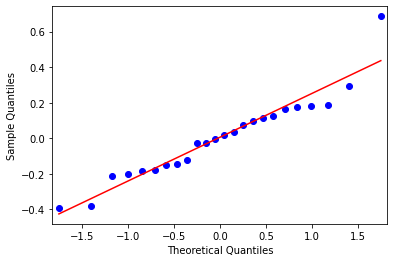

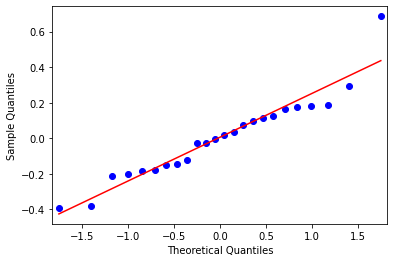

In [49]:
from statsmodels import graphics
influence  = result3.get_influence()
yhat = result3.mu
standardized_residuals  = influence.resid_studentized
graphics.gofplots.qqplot(standardized_residuals, line='r')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


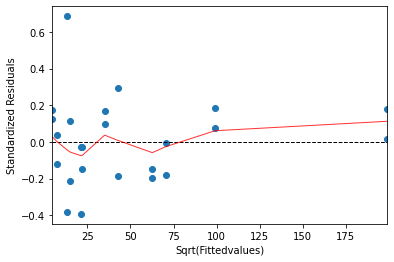

In [50]:

plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.scatter(np.sqrt(yhat), standardized_residuals)
plt.xlabel('Sqrt(Fittedvalues)')
plt.ylabel('Standardized Residuals')
sns.regplot(np.sqrt(yhat), standardized_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

In [51]:
#Cook's distance
cooks = influence.cooks_distance
cooks

(array([1.97272582e-03, 1.58840252e-05, 1.41477024e-03, 6.04444042e-03,
        1.02873053e-03, 1.73770971e-03, 4.38092017e-03, 4.39746294e-02,
        2.15030900e-03, 3.05379789e-04, 5.14246392e-03, 4.00230104e-05,
        7.21944445e-07, 1.41633867e-03, 1.85495454e-03, 7.83912111e-04,
        4.00872751e-05, 1.04278956e-03, 8.33116648e-04, 1.72000036e-03,
        1.63995965e-03, 5.23436191e-04, 6.86473341e-04, 7.55644733e-05]),
 array([0.99999938, 1.        , 0.99999973, 0.99998998, 0.99999988,
        0.99999955, 0.9999955 , 0.99868533, 0.99999924, 0.99999999,
        0.99999329, 1.        , 1.        , 0.99999973, 0.99999947,
        0.99999994, 1.        , 0.99999987, 0.99999993, 0.99999956,
        0.99999961, 0.99999998, 0.99999996, 1.        ]))

In [52]:
#Leverage
model_leverage = influence.hat_matrix_diag
model_leverage

array([0.23489448, 0.20622155, 0.17054146, 0.25739547, 0.19143818,
       0.18110534, 0.1316919 , 0.31853682, 0.23561901, 0.21590332,
       0.14293707, 0.21913697, 0.21520645, 0.18091651, 0.17264831,
       0.23457651, 0.21467081, 0.19052035, 0.21277889, 0.22096269,
       0.22714563, 0.21520758, 0.19006526, 0.21987942])

Text(0, 0.5, "Cook's distance")

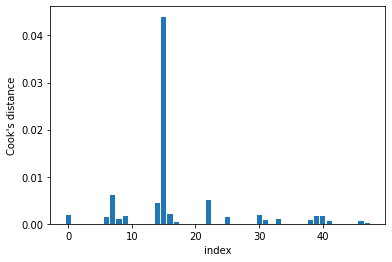

In [53]:
x = data_final3.index
y = cooks[0]
plt.bar(x, y)
plt.xlabel("index")
plt.ylabel("Cook's distance")

**CHẠY MODEL QUASI POISSON**

In [54]:
import rpy2.robjects as ro
 
from rpy2.robjects import pandas2ri
 
pandas2ri.activate()
 
rdf = pandas2ri.py2rpy_pandasdataframe(data_final)

In [55]:
qpoisson = ro.r.glm('Cases ~ Age + Cities + Case_info', data = rdf, family = ro.r('quasipoisson(link = log)'))
print(ro.r.summary(qpoisson))



Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

In [56]:
qpoisson2 = ro.r.glm('Cases ~ Age *Cities + Cities * Case_info + Case_info * Age', data = rdf, family = ro.r('quasipoisson(link = log)'))
print(ro.r.summary(qpoisson2))



Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

**REFERENCE: Kiểm tra lại với R cho 1 số mô hình để đôi chiếu với kết quả chạy = Python**

#Upload file datafinal.csv 
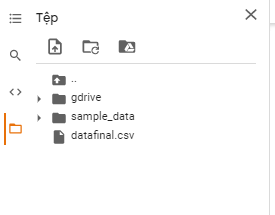

In [58]:
%%R
data <- read.csv("/content/datafinal.csv", stringsAsFactors = FALSE, header = TRUE)

In [59]:
%%R
data

   STT    Age      Cities         Case_info Client_Gender Cases  X
1    0  adult Large urban                CC        FEMALE 45818 NA
2    1  adult Large urban                CC          MALE 40225 NA
3    2  adult Large urban NO KNOWN EPI LINK        FEMALE 36451 NA
4    3  adult Large urban NO KNOWN EPI LINK          MALE 40915 NA
5    4  adult Large urban                OB        FEMALE 16860 NA
6    5  adult Large urban                OB          MALE 15310 NA
7    6  adult Large urban            TRAVEL        FEMALE  1507 NA
8    7  adult Large urban            TRAVEL          MALE  2275 NA
9    8  adult      Medium                CC        FEMALE  3408 NA
10   9  adult      Medium                CC          MALE  3224 NA
11  10  adult      Medium NO KNOWN EPI LINK        FEMALE  1414 NA
12  11  adult      Medium NO KNOWN EPI LINK          MALE  1303 NA
13  12  adult      Medium                OB        FEMALE  1229 NA
14  13  adult      Medium                OB          MALE  138

In [62]:
%%R
#Mô hình nhị thức âm
library(MASS)
mod <- glm(Cases ~ Age*Cities+Cities*Case_info+Case_info*Age, family = negative.binomial(theta=1, link=log), data = data)
summary(mod)


Call:
glm(formula = Cases ~ Age * Cities + Cities * Case_info + Case_info * 
    Age, family = negative.binomial(theta = 1, link = log), data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.48320  -0.06263   0.00053   0.06291   0.44245  

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                             10.67627    0.10631 100.425  < 2e-16
Agesenior                               -2.21664    0.13025 -17.018  < 2e-16
Ageyouth                                -0.04139    0.13021  -0.318 0.751941
CitiesMedium                            -2.55988    0.13025 -19.654  < 2e-16
CitiesSmall                             -1.39202    0.13022 -10.690 2.72e-14
Case_infoNO KNOWN EPI LINK              -0.13981    0.13724  -1.019 0.313462
Case_infoOB                             -1.01042    0.13724  -7.362 2.05e-09
Case_infoTRAVEL                         -3.09030    0.13734 -22.501  < 2e-16
Agesenior:CitiesM

In [63]:
%%R
pchisq(deviance(mod), df.m2 <- df.residual( mod ), lower=FALSE)

[1] 1


In [64]:
%%R
#Mô hình poisson
mod2 <- glm(Cases~Age * Cities + Case_info*Age + Age*Case_info, family = poisson(link=log), data = data)
summary(mod2)


Call:
glm(formula = Cases ~ Age * Cities + Case_info * Age + Age * 
    Case_info, family = poisson(link = log), data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-27.0750   -5.7305    0.7861    5.8345   26.2678  

Coefficients:
                                      Estimate Std. Error  z value Pr(>|z|)    
(Intercept)                          10.704185   0.003138 3411.636  < 2e-16 ***
Agesenior                            -2.226526   0.009782 -227.625  < 2e-16 ***
Ageyouth                             -0.016511   0.004511   -3.660 0.000252 ***
CitiesMedium                         -2.780571   0.009269 -299.984  < 2e-16 ***
CitiesSmall                          -1.495860   0.005235 -285.752  < 2e-16 ***
Case_infoNO KNOWN EPI LINK           -0.180485   0.004380  -41.208  < 2e-16 ***
Case_infoOB                          -1.021024   0.005741 -177.847  < 2e-16 ***
Case_infoTRAVEL                      -3.150905   0.014581 -216.098  < 2e-16 ***
Agesenior:Citi

In [65]:
%%R
pchisq(deviance(mod2), df.m2 <- df.residual( mod2 ), lower=FALSE)

[1] 0


In [66]:
%%R
#Mô hình quasi poisson
mod3 <- glm(Cases~Age + Cities + Case_info, family = quasipoisson( link=log), data = data)
summary(mod3)


Call:
glm(formula = Cases ~ Age + Cities + Case_info, family = quasipoisson(link = log), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-53.812  -12.017   -2.630    8.244  102.760  

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                10.80955    0.07271 148.669  < 2e-16 ***
Agesenior                  -1.74581    0.14487 -12.051  < 2e-16 ***
Ageyouth                   -0.35409    0.08696  -4.072 0.000131 ***
CitiesMedium               -2.74789    0.18782 -14.630  < 2e-16 ***
CitiesSmall                -1.54189    0.10977 -14.046  < 2e-16 ***
Case_infoNO KNOWN EPI LINK -0.42931    0.09243  -4.645 1.74e-05 ***
Case_infoOB                -1.07927    0.11524  -9.366 1.31e-13 ***
Case_infoTRAVEL            -3.32563    0.31154 -10.675 7.56e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 799.4703)

    Null devia

In [67]:
%%R
pchisq(deviance(mod3), df.m2 <- df.residual( mod3 ), lower=FALSE)

[1] 0


**KẾT QUẢ GIỐNG VỚI CHẠY BẰNG PYTHON**